In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pandas_summary import DataFrameSummary
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('../..')
from src import utils

In [2]:
DATA        = Path('data')
RAW         = DATA/'raw'
INTERIM     = DATA/'interim'
PROCESSED   = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [3]:
challenge  = pd.read_csv(RAW/'Challenge_20180423.csv', low_memory=False)
customer   = pd.read_csv(RAW/'Customer.csv', low_memory=False)
isin       = pd.read_csv(RAW/'Isin.csv', low_memory=False)
market     = pd.read_csv(RAW/'Market.csv', low_memory=False)
macro      = pd.read_csv(RAW/'MarketData_Macro.csv', low_memory=False)
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
trade      = pd.read_csv(RAW/'Trade.csv', low_memory=False)

In [4]:
from src.utils import make_val_set, add_datediffs, add_dayscount, preprocessing_pipeline

In [23]:
week_labelsweek_lab = [ 20180219, 20180226, 20180305, 20180312, 20180319, 
                        20180326, 20180402, 20180409, 20180416, 20180423]

In [34]:
%%time
weeks = [make_val_set(trade[trade.TradeDateKey.apply(lambda x: w1<=x<w2)], 
                    challenge) for w1, w2 in zip(week_labels[:-1], week_labels[1:])]

CPU times: user 5min 11s, sys: 1.13 s, total: 5min 12s
Wall time: 5min 12s


In [36]:
%%time
for w in weeks:
    add_datediffs(w, trade[trade.TradeDateKey > 20180000])
    add_dayscount(w, trade[trade.TradeDateKey > 20180000])

CPU times: user 11min 40s, sys: 4.26 s, total: 11min 44s
Wall time: 11min 44s


In [37]:
def fill_variabilities(df, time_days=7):
    df['Yield_var'] = 0.0
    df['ZSpread_var'] = 0.0
    df['Price_var'] = 0.0
    
    for ix in df.IsinIdx.unique():
        temp = df.loc[df.IsinIdx == ix].reset_index()
        fill_variabilites_per_index(df, temp, time_days)

In [38]:
def fill_variabilites_per_index(df, temp, time_days=7):
    for ix, _ in temp.iterrows():
        if ix <= 1:
            continue
        start = ix - time_days - 1
        if start < 0:
            start = 0
        df.set_value(temp.loc[ix]['index'], 'Yield_var', temp.loc[start:ix - 1].Yield.var())
        df.set_value(temp.loc[ix]['index'], 'ZSpread_var', temp.loc[start:ix - 1].ZSpread.var())
        df.set_value(temp.loc[ix]['index'], 'Price_var', temp.loc[start:ix - 1].Price.var())    

In [39]:
w.head()

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest,DaysSinceBuySell,DaysSinceTransaction,DaysSinceCustomerActivity,DaysSinceBondActivity,DaysCountBuySell,DaysCountTransaction,DaysCountCustomerActivity,DaysCountBondActivity
0,20180205,0,21856,Buy,0.0,219,219,4,6,0,0,5,4
1,20180205,0,21856,Sell,0.0,219,219,4,6,0,0,5,4
2,20180205,0,24944,Buy,0.0,219,219,4,21,0,0,5,3
3,20180205,0,24944,Sell,0.0,219,219,4,21,0,0,5,3
4,20180205,0,25992,Buy,0.0,219,219,4,3,0,0,5,15


In [29]:
# %%time
# fill_variabilities(market, time_days=7)

In [30]:
# # To simplify process
# market.to_feather(PROCESSED/'market_with_var_7.feather')

In [31]:
def calculate_SMA(df, period, start=0, column='Price'):
    """
        Returning the First SMA to calculate the first EMA
    """
    return df.loc[start:period + start - 1][column].sum() / period

In [32]:
def calculate_EMA(prev_EMA, price, multiplier):
    """
        Returning the EMA for t time
    """
    return (price - prev_EMA) * multiplier + prev_EMA

In [33]:
def fill_EMA(df, period=20, name_column='EMA_Price_Short_term', column='Price'):
    """
        Exponential moving averages (EMAs) reduce the lag by applying more weight to recent prices
    """
    first_SMA = calculate_SMA(df, period, column=column)
    multiplier= (2.0 / (period + 1))    
    df[name_column] = np.nan
    for ix, _ in df.iterrows():
        if ix < period - 1:
            continue
        elif ix == period - 1:
            df.set_value(ix, name_column, first_SMA)
            prev_EMA = first_SMA
        else:
            if np.isnan(df.loc[ix][column]):
                df.set_value(ix, column, (df.loc[ix-1][column] + df.loc[ix+1][column]) / 2)
            actual_EMA = calculate_EMA(prev_EMA, df.loc[ix][column], multiplier)
            prev_EMA = actual_EMA
            df.set_value(ix, name_column, actual_EMA)
        

In [ ]:
# market_temp = market.copy()
# fill_EMA(market_temp, period=20, name_column='EMA_20')

In [ ]:
# fill_EMA(market_temp, period=150, name_column='EMA_150')

In [ ]:
# market_temp.head()

In [18]:
%%time
for i, w in enumerate(weeks):
    weeks[i] = preprocessing_pipeline(w, customer, isin, trade)  

CPU times: user 2.42 s, sys: 564 ms, total: 2.99 s
Wall time: 3.01 s


In [ ]:
test = pd.read_feather(PROCESSED/'week_0423_diffscount.feather')
#test.drop(['Yield', 'ZSpread', 'Price'], axis=1, inplace=True)

In [ ]:
test.head(1)

In [ ]:
def fill_test_variabilities(test, market, time_days=7):
    test['Yield_var'] = 0.0
    test['ZSpread_var'] = 0.0
    test['Price_var'] = 0.0
    
    for ix in test.IsinIdx.unique():
        temp = test.loc[test.IsinIdx == ix].reset_index()
        for ix, _ in temp.iterrows():
            test.set_value(temp.loc[ix]['index'], 'Yield_var', market.tail(time_days).Yield.var())
            test.set_value(temp.loc[ix]['index'], 'ZSpread_var', market.tail(time_days).ZSpread.var())
            test.set_value(temp.loc[ix]['index'], 'Price_var', market.tail(time_days).Price.var())  

In [ ]:
# %%time
# fill_test_variabilities(test, market, time_days=7)

In [ ]:
test.drop(['index'], axis=1, inplace=True)

In [ ]:
weeks[0].columns

In [ ]:
test.columns

In [ ]:
weeks.append(test)

In [ ]:
%%time
for w, name in zip(weeks, week_labels):
    w.reset_index().to_feather(PROCESSED/f'week_{name % 10000:04}_diffscount.feather')

In [ ]:
len(weeks)

In [ ]:
# %%time
# weeks_aux = []
# for w, name in zip(weeks, week_labels):
#     weeks_aux.append(pd.read_feather(PROCESSED/f'week_{name % 10000:04}_diffscount.feather'))

# Macro Table

In [40]:
macro.head()

,DateKey,SSE,DAX,EUROSTOXX,VSTOXX,FTSE100,HSI,NIKKEI,DOWJONES_INDU,SP500,VIX,FX_USD.ARS,FX_USD.AUD,FX_USD.BRL,FX_USD.CAD,FX_USD.CHF,FX_USD.CNO,FX_USD.CNY,FX_USD.EUR,FX_USD.GBP,FX_USD.HKD,FX_USD.IDR,FX_USD.JPY,FX_USD.NOK,FX_USD.SGD,FX_USD.TRY,FX_USD.ZAR,MoneyMarket_ARS3M,MoneyMarket_AUD3M,MoneyMarket_CAD3M,MoneyMarket_CHF3M,MoneyMarket_CNO3M,MoneyMarket_CNY3M,MoneyMarket_EUR3M,MoneyMarket_GBP3M,MoneyMarket_HKD3M,MoneyMarket_IDR3M,MoneyMarket_JPY3M,MoneyMarket_NOK3M,MoneyMarket_SGD3M,MoneyMarket_TRY3M,MoneyMarket_USD3M,MoneyMarket_ZAR3M,Swap_ARS10Y,Swap_ARS2Y,Swap_ARS5Y,Swap_AUD10Y,Swap_AUD2Y,Swap_AUD30Y,Swap_AUD5Y,Swap_BRL10Y,Swap_BRL2Y,Swap_BRL5Y,Swap_CAD10Y,Swap_CAD2Y,Swap_CAD30Y,Swap_CAD5Y,Swap_CHF10Y,Swap_CHF2Y,Swap_CHF30Y,Swap_CHF5Y,Swap_CNH10Y,Swap_CNH2Y,Swap_CNH30Y,Swap_CNH5Y,Swap_CNO10Y,Swap_CNO2Y,Swap_CNO30Y,Swap_CNO5Y,Swap_CNY10Y,Swap_CNY2Y,Swap_CNY30Y,Swap_CNY5Y,Swap_EUR10Y,Swap_EUR2Y,Swap_EUR30Y,Swap_EUR5Y,Swap_GBP10Y,Swap_GBP2Y,Swap_GBP30Y,Swap_GBP5Y,Swap_HKD10Y,Swap_HKD2Y,Swap_HKD30Y,Swap_HKD5Y,Swap_IDR10Y,Swap_IDR2Y,Swap_IDR30Y,Swap_IDR5Y,Swap_JPY10Y,Swap_JPY2Y,Swap_JPY30Y,Swap_JPY5Y,Swap_NOK10Y,Swap_NOK2Y,Swap_NOK30Y,Swap_NOK5Y,Swap_SGD10Y,Swap_SGD2Y,Swap_SGD30Y,Swap_SGD5Y,Swap_TRY10Y,Swap_TRY2Y,Swap_TRY5Y,Swap_USD10Y,Swap_USD2Y,Swap_USD30Y,Swap_USD5Y,Swap_ZAR10Y,Swap_ZAR2Y,Swap_ZAR30Y,Swap_ZAR5Y
0,20150101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.20,0.116959,0.81620,0.377658,0.861030,1.006264,0.161512,0.163399,1.2101,1.55775,0.128941,0.000081,0.008341,0.133451,0.756287,0.428964,0.086457,35.230452,2.724540,1.303309,-0.063143,3.701588,3.617925,0.077487,0.561227,0.381829,7.17183,0.112078,1.459648,0.709986,10.001685,0.256570,6.130798,19.989643,29.980614,21.985733,3.041150,2.398950,3.625076,2.558248,NaN,NaN,NaN,2.277279,NaN,2.760043,1.775859,0.409878,NaN,1.082563,-0.046046,3.749868,3.418686,NaN,3.549519,3.750081,3.419989,NaN,3.550031,3.439794,3.218679,NaN,3.239508,0.697389,NaN,1.408397,0.233572,NaN,NaN,NaN,NaN,2.252274,0.95467,NaN,1.814259,8.955845,8.368177,9.552123,8.708471,0.444559,NaN,1.233032,0.180984,1.806932,NaN,2.179804,1.295793,NaN,NaN,NaN,NaN,9.885583,10.069276,9.915120,2.295037,NaN,2.712112,1.774452,7.963276,6.856526,8.331874,7.403867
1,20150102,NaN,9764.73,3139.44,26.2531,6547.80,23857.82,NaN,17832.99,2058.20,17.79,0.116891,0.81140,0.371292,0.851136,0.998851,0.161186,0.163292,1.2008,1.53340,0.128934,0.000080,0.008308,0.131841,0.752757,0.427241,0.085609,33.000000,2.736281,1.302850,-0.063000,3.701588,3.617925,0.077179,0.563380,0.385000,7.10000,0.112078,1.490000,0.790000,10.020000,0.255218,6.125000,20.000000,30.000000,22.000000,3.108394,2.452905,3.692179,2.625847,11.767860,12.807338,12.202677,2.231223,1.445105,2.716551,1.748069,0.367391,NaN,1.040147,-0.058452,3.750081,3.419989,NaN,3.550031,3.750081,3.419989,NaN,3.550031,3.439794,3.218679,NaN,3.239508,0.640191,0.062120,1.347191,0.211268,1.674890,0.810358,2.109754,1.305976,2.290000,0.97500,2.751960,1.840000,8.950000,8.350000,9.550000,8.700000,0.444559,NaN,1.233032,0.180984,1.794443,1.100220,2.168744,1.280511,2.447394,1.132505,2.951900,1.948474,9.946260,10.151881,9.976101,2.236910,0.893242,2.647499,1.746344,7.940000,6.840000,8.310000,7.390000
2,20150105,3350.519,9473.16,3023.14,29.6236,6417.16,23721.32,17408.71,17501.65,2020.58,19.92,0.116782,0.80905,0.366757,0.850268,0.993764,0.160822,0.163265,1.1939,1.52555,0.128926,0.000079,0.008366,0.131277,0.749260,0.429304,0.085426,32.000000,2.742523,1.303171,-0.063000,3.749732,3.691439,0.075252,0.563380,0.383570,7.10000,0.112140,1.450000,0.875000,9.993400,0.254194,6.125000,20.000000,30.000000,22.000000,3.007227,2.423082,3.591836,2.566016,11.809585,12.736379,12.154331,2.180266,1.420899,2.668708,1.713829,0.350011,-0.263049,0.981356,-0.069792,3.700010,3.405070,NaN,3.500016,3.700010,3.405070,NaN,3.500016,3.450010,3.230070,NaN,3.250016,0.658914,0.063256,1.351414,0.220293,1.613752,0.799833,2.043961,1.251222,2.190000,0.94000,2.652800,1.750000,8.950000,8.350000,9.550000,8.700000,0.436972,0.112315,1.225011,0.178599,1.747772,1.06362

In [69]:
macro['Date'] = pd.to_datetime(macro['DateKey'], format = '%Y%m%d')

In [70]:
import datetime
macro_filtered_dates = macro[macro['Date'] > datetime.date(2018,1,1)]

In [71]:
macro_filtered_dates.head()

,DateKey,SSE,DAX,EUROSTOXX,VSTOXX,FTSE100,HSI,NIKKEI,DOWJONES_INDU,SP500,VIX,FX_USD.ARS,FX_USD.AUD,FX_USD.BRL,FX_USD.CAD,FX_USD.CHF,FX_USD.CNO,FX_USD.CNY,FX_USD.EUR,FX_USD.GBP,FX_USD.HKD,FX_USD.IDR,FX_USD.JPY,FX_USD.NOK,FX_USD.SGD,FX_USD.TRY,FX_USD.ZAR,MoneyMarket_ARS3M,MoneyMarket_AUD3M,MoneyMarket_CAD3M,MoneyMarket_CHF3M,MoneyMarket_CNO3M,MoneyMarket_CNY3M,MoneyMarket_EUR3M,MoneyMarket_GBP3M,MoneyMarket_HKD3M,MoneyMarket_IDR3M,MoneyMarket_JPY3M,MoneyMarket_NOK3M,MoneyMarket_SGD3M,MoneyMarket_TRY3M,MoneyMarket_USD3M,MoneyMarket_ZAR3M,Swap_ARS10Y,Swap_ARS2Y,Swap_ARS5Y,Swap_AUD10Y,Swap_AUD2Y,Swap_AUD30Y,Swap_AUD5Y,Swap_BRL10Y,Swap_BRL2Y,Swap_BRL5Y,Swap_CAD10Y,Swap_CAD2Y,Swap_CAD30Y,Swap_CAD5Y,Swap_CHF10Y,Swap_CHF2Y,Swap_CHF30Y,Swap_CHF5Y,Swap_CNH10Y,Swap_CNH2Y,Swap_CNH30Y,Swap_CNH5Y,Swap_CNO10Y,Swap_CNO2Y,Swap_CNO30Y,Swap_CNO5Y,Swap_CNY10Y,Swap_CNY2Y,Swap_CNY30Y,Swap_CNY5Y,Swap_EUR10Y,Swap_EUR2Y,Swap_EUR30Y,Swap_EUR5Y,Swap_GBP10Y,Swap_GBP2Y,Swap_GBP30Y,Swap_GBP5Y,Swap_HKD10Y,Swap_HKD2Y,Swap_HKD30Y,Swap_HKD5Y,Swap_IDR10Y,Swap_IDR2Y,Swap_IDR30Y,Swap_IDR5Y,Swap_JPY10Y,Swap_JPY2Y,Swap_JPY30Y,Swap_JPY5Y,Swap_NOK10Y,Swap_NOK2Y,Swap_NOK30Y,Swap_NOK5Y,Swap_SGD10Y,Swap_SGD2Y,Swap_SGD30Y,Swap_SGD5Y,Swap_TRY10Y,Swap_TRY2Y,Swap_TRY5Y,Swap_USD10Y,Swap_USD2Y,Swap_USD30Y,Swap_USD5Y,Swap_ZAR10Y,Swap_ZAR2Y,Swap_ZAR30Y,Swap_ZAR5Y,Date
783,20180102,3348.326,12871.39,3490.19,13.3676,7648.10,30515.31,23135.6350,24824.01,2695.81,9.77,0.054345,0.78315,0.306871,0.799488,1.028833,0.153917,0.154060,1.20540,1.35960,0.127935,0.000074,0.008907,0.123206,0.751343,0.265499,0.080354,20.757317,1.789506,1.553006,-0.746,3.490,3.490000,-0.328926,0.51688,1.305262,5.44436,-0.02850,0.81,1.188218,12.397863,1.689774,7.158,12.0,16.55,13.2,2.697801,2.027742,3.070959,2.373493,10.219384,7.889705,9.575841,2.428293,2.072766,2.584664,2.277706,0.118177,-0.585964,0.671887,-0.271698,4.190,3.760,4.490,4.040,4.190,3.760,4.490,4.040,4.190,3.760,4.490,4.040,0.823215,-0.214006,1.491215,0.235351,1.279398,0.762844,1.445281,1.023251,2.2650,1.785,2.631406,2.090,8.95,8.35,9.55,8.7,0.206231,0.021328,0.758477,0.070991,1.848695,1.028187,2.082995,1.443108,2.109703,1.431658,2.520113,1.761954,11.729386,14.137940,12.796034,2.440616,2.102918,2.600007,2.282274,7.910,6.920,8.01,7.320,2018-01-02
784,20180103,3369.108,12978.21,3509.88,12.1367,7671.11,30560.95,23320.9825,24922.68,2713.06,9.15,0.054215,0.78395,0.308471,0.797894,1.023699,0.153799,0.153917,1.20175,1.35180,0.127916,0.000074,0.008887,0.123311,0.752587,0.265643,0.080814,22.300000,1.788787,1.549794,-0.746,3.485,3.485000,-0.328935,0.51688,1.300765,5.36861,-0.02850,0.81,1.203637,12.487113,1.690810,7.158,12.0,16.55,13.2,2.728053,2.019378,3.103524,2.384085,10.187530,7.886683,9.529469,2.388908,2.048392,2.559427,2.237078,0.107358,-0.588414,0.661793,-0.278538,4.190,3.755,4.490,4.040,4.190,3.755,4.490,4.040,4.190,3.755,4.490,4.040,0.805251,-0.215338,1.472751,0.220378,1.226034,0.740304,1.393496,0.979680,2.3225,1.805,2.686278,2.130,8.95,8.35,9.55,8.7,0.206231,0.021273,0.758477,0.070991,1.843464,1.032733,2.077751,1.437849,2.143875,1.449134,2.565110,1.782949,11.819876,14.213805,12.881647,2.426702,2.109261,2.579459,2.284100,7.910,6.925,8.00,7.330,2018-01-03
785,20180104,3385.710,13167.89,3568.88,11.4105,7695.88,30736.48,23506.3300,25075.13,2723.99,9.22,0.053677,0.78645,0.309789,0.800416,1.025983,0.153610,0.153953,1.20720,1.35545,0.127902,0.000074,0.008870,0.124088,0.752559,0.266592,0.081136,23.000000,1.790552,1.549288,-0.738,3.435,3.440000,-0.328906,0.51750,1.290783,5.30861,-0.02633,0.80,1.165475,12.420359,1.703350,7.158,12.0,16.55,13.2,2.694798,2.002299,3.061764,2.352675,10.216117,7.903934,9.550466,2.418228,2.057166,2.571133,2.262801,0.106489,-0.586351,0.660439,-0.278750,4.180,3.735,4.480,4.030,4.180,3.735,4.480,4.030,4.175,3.735,4.475,4.025,0.803344,-0.212385,1.456344,0.230821,1.245290,0.748376,1.412793,0.994975,2.3250,1.790,2.688188,2.125,8.95,8.35,9.55,8.7,0.211707,0.021217,0.767608,0.074070,1.829604,1.018644,2.063906,1.423943,2.140893,1.434658,2.562

In [73]:
macro_filtered_dates.set_index('Date', inplace=True)

In [76]:
print(macro_filtered_dates.shape)
macro_filtered_dates.head()

(94, 112)


,DateKey,SSE,DAX,EUROSTOXX,VSTOXX,FTSE100,HSI,NIKKEI,DOWJONES_INDU,SP500,VIX,FX_USD.ARS,FX_USD.AUD,FX_USD.BRL,FX_USD.CAD,FX_USD.CHF,FX_USD.CNO,FX_USD.CNY,FX_USD.EUR,FX_USD.GBP,FX_USD.HKD,FX_USD.IDR,FX_USD.JPY,FX_USD.NOK,FX_USD.SGD,FX_USD.TRY,FX_USD.ZAR,MoneyMarket_ARS3M,MoneyMarket_AUD3M,MoneyMarket_CAD3M,MoneyMarket_CHF3M,MoneyMarket_CNO3M,MoneyMarket_CNY3M,MoneyMarket_EUR3M,MoneyMarket_GBP3M,MoneyMarket_HKD3M,MoneyMarket_IDR3M,MoneyMarket_JPY3M,MoneyMarket_NOK3M,MoneyMarket_SGD3M,MoneyMarket_TRY3M,MoneyMarket_USD3M,MoneyMarket_ZAR3M,Swap_ARS10Y,Swap_ARS2Y,Swap_ARS5Y,Swap_AUD10Y,Swap_AUD2Y,Swap_AUD30Y,Swap_AUD5Y,Swap_BRL10Y,Swap_BRL2Y,Swap_BRL5Y,Swap_CAD10Y,Swap_CAD2Y,Swap_CAD30Y,Swap_CAD5Y,Swap_CHF10Y,Swap_CHF2Y,Swap_CHF30Y,Swap_CHF5Y,Swap_CNH10Y,Swap_CNH2Y,Swap_CNH30Y,Swap_CNH5Y,Swap_CNO10Y,Swap_CNO2Y,Swap_CNO30Y,Swap_CNO5Y,Swap_CNY10Y,Swap_CNY2Y,Swap_CNY30Y,Swap_CNY5Y,Swap_EUR10Y,Swap_EUR2Y,Swap_EUR30Y,Swap_EUR5Y,Swap_GBP10Y,Swap_GBP2Y,Swap_GBP30Y,Swap_GBP5Y,Swap_HKD10Y,Swap_HKD2Y,Swap_HKD30Y,Swap_HKD5Y,Swap_IDR10Y,Swap_IDR2Y,Swap_IDR30Y,Swap_IDR5Y,Swap_JPY10Y,Swap_JPY2Y,Swap_JPY30Y,Swap_JPY5Y,Swap_NOK10Y,Swap_NOK2Y,Swap_NOK30Y,Swap_NOK5Y,Swap_SGD10Y,Swap_SGD2Y,Swap_SGD30Y,Swap_SGD5Y,Swap_TRY10Y,Swap_TRY2Y,Swap_TRY5Y,Swap_USD10Y,Swap_USD2Y,Swap_USD30Y,Swap_USD5Y,Swap_ZAR10Y,Swap_ZAR2Y,Swap_ZAR30Y,Swap_ZAR5Y
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,20180102,3348.326,12871.39,3490.19,13.3676,7648.10,30515.31,23135.6350,24824.01,2695.81,9.77,0.054345,0.78315,0.306871,0.799488,1.028833,0.153917,0.154060,1.20540,1.35960,0.127935,0.000074,0.008907,0.123206,0.751343,0.265499,0.080354,20.757317,1.789506,1.553006,-0.746,3.490,3.490000,-0.328926,0.51688,1.305262,5.44436,-0.02850,0.81,1.188218,12.397863,1.689774,7.158,12.0,16.55,13.2,2.697801,2.027742,3.070959,2.373493,10.219384,7.889705,9.575841,2.428293,2.072766,2.584664,2.277706,0.118177,-0.585964,0.671887,-0.271698,4.190,3.760,4.490,4.040,4.190,3.760,4.490,4.040,4.190,3.760,4.490,4.040,0.823215,-0.214006,1.491215,0.235351,1.279398,0.762844,1.445281,1.023251,2.2650,1.785,2.631406,2.090,8.95,8.35,9.55,8.7,0.206231,0.021328,0.758477,0.070991,1.848695,1.028187,2.082995,1.443108,2.109703,1.431658,2.520113,1.761954,11.729386,14.137940,12.796034,2.440616,2.102918,2.600007,2.282274,7.910,6.920,8.01,7.320
2018-01-03,20180103,3369.108,12978.21,3509.88,12.1367,7671.11,30560.95,23320.9825,24922.68,2713.06,9.15,0.054215,0.78395,0.308471,0.797894,1.023699,0.153799,0.153917,1.20175,1.35180,0.127916,0.000074,0.008887,0.123311,0.752587,0.265643,0.080814,22.300000,1.788787,1.549794,-0.746,3.485,3.485000,-0.328935,0.51688,1.300765,5.36861,-0.02850,0.81,1.203637,12.487113,1.690810,7.158,12.0,16.55,13.2,2.728053,2.019378,3.103524,2.384085,10.187530,7.886683,9.529469,2.388908,2.048392,2.559427,2.237078,0.107358,-0.588414,0.661793,-0.278538,4.190,3.755,4.490,4.040,4.190,3.755,4.490,4.040,4.190,3.755,4.490,4.040,0.805251,-0.215338,1.472751,0.220378,1.226034,0.740304,1.393496,0.979680,2.3225,1.805,2.686278,2.130,8.95,8.35,9.55,8.7,0.206231,0.021273,0.758477,0.070991,1.843464,1.032733,2.077751,1.437849,2.143875,1.449134,2.565110,1.782949,11.819876,14.213805,12.881647,2.426702,2.109261,2.579459,2.284100,7.910,6.925,8.00,7.330
2018-01-04,20180104,3385.710,13167.89,3568.88,11.4105,7695.88,30736.48,23506.3300,25075.13,2723.99,9.22,0.053677,0.78645,0.309789,0.800416,1.025983,0.153610,0.153953,1.20720,1.35545,0.127902,0.000074,0.008870,0.124088,0.752559,0.266592,0.081136,23.000000,1.790552,1.549288,-0.738,3.435,3.440000,-0.328906,0.51750,1.290783,5.30861,-0.02633,0.80,1.165475,12.420359,1.703350,7.158,12.0,16.55,13.2,2.694798,2.002299,3.061764,2.352675,10.216117,7.903934,9.550466,2.418228,2.057166,2.571133,2.262801,0.106489,-0.586351,0.660439,-0.278750,4.180,3.735,4.480,4.030,4.180,3.735,4.480,4.030,4.175,3.735,4.475,4.025,0.803344,-0.212385,1.456344,0.230821,1.245290,0.748376,1.412793,0.994975,2.3250,1.790,2.688188,2.125,8.9

In [81]:
short_rolling = macro_filtered_dates.rolling(window=5).mean()
short_rolling.tail()

,DateKey,SSE,DAX,EUROSTOXX,VSTOXX,FTSE100,HSI,NIKKEI,DOWJONES_INDU,SP500,VIX,FX_USD.ARS,FX_USD.AUD,FX_USD.BRL,FX_USD.CAD,FX_USD.CHF,FX_USD.CNO,FX_USD.CNY,FX_USD.EUR,FX_USD.GBP,FX_USD.HKD,FX_USD.IDR,FX_USD.JPY,FX_USD.NOK,FX_USD.SGD,FX_USD.TRY,FX_USD.ZAR,MoneyMarket_ARS3M,MoneyMarket_AUD3M,MoneyMarket_CAD3M,MoneyMarket_CHF3M,MoneyMarket_CNO3M,MoneyMarket_CNY3M,MoneyMarket_EUR3M,MoneyMarket_GBP3M,MoneyMarket_HKD3M,MoneyMarket_IDR3M,MoneyMarket_JPY3M,MoneyMarket_NOK3M,MoneyMarket_SGD3M,MoneyMarket_TRY3M,MoneyMarket_USD3M,MoneyMarket_ZAR3M,Swap_ARS10Y,Swap_ARS2Y,Swap_ARS5Y,Swap_AUD10Y,Swap_AUD2Y,Swap_AUD30Y,Swap_AUD5Y,Swap_BRL10Y,Swap_BRL2Y,Swap_BRL5Y,Swap_CAD10Y,Swap_CAD2Y,Swap_CAD30Y,Swap_CAD5Y,Swap_CHF10Y,Swap_CHF2Y,Swap_CHF30Y,Swap_CHF5Y,Swap_CNH10Y,Swap_CNH2Y,Swap_CNH30Y,Swap_CNH5Y,Swap_CNO10Y,Swap_CNO2Y,Swap_CNO30Y,Swap_CNO5Y,Swap_CNY10Y,Swap_CNY2Y,Swap_CNY30Y,Swap_CNY5Y,Swap_EUR10Y,Swap_EUR2Y,Swap_EUR30Y,Swap_EUR5Y,Swap_GBP10Y,Swap_GBP2Y,Swap_GBP30Y,Swap_GBP5Y,Swap_HKD10Y,Swap_HKD2Y,Swap_HKD30Y,Swap_HKD5Y,Swap_IDR10Y,Swap_IDR2Y,Swap_IDR30Y,Swap_IDR5Y,Swap_JPY10Y,Swap_JPY2Y,Swap_JPY30Y,Swap_JPY5Y,Swap_NOK10Y,Swap_NOK2Y,Swap_NOK30Y,Swap_NOK5Y,Swap_SGD10Y,Swap_SGD2Y,Swap_SGD30Y,Swap_SGD5Y,Swap_TRY10Y,Swap_TRY2Y,Swap_TRY5Y,Swap_USD10Y,Swap_USD2Y,Swap_USD30Y,Swap_USD5Y,Swap_ZAR10Y,Swap_ZAR2Y,Swap_ZAR30Y,Swap_ZAR5Y
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-05-07,20180503.4,3098.248533,12793.464,3546.790,13.66866,7539.967,30344.835,22477.582000,24114.802,2651.250,15.376,0.046346,0.75157,0.283516,0.777756,1.000921,0.157436,0.157370,1.19698,1.35787,0.127398,0.000072,0.009142,0.123894,0.750303,0.238042,0.079201,33.242077,2.012702,1.752974,-0.727096,3.156206,3.156791,-0.328370,0.687841,1.685830,5.936321,-0.031500,1.120093,1.602264,13.652208,2.363414,6.899402,15.297157,20.24316,17.296192,2.811459,2.132416,3.024131,2.460960,9.907476,7.361700,9.198003,2.693301,2.280740,2.773333,2.542518,0.351483,-0.553307,0.890523,-0.118144,3.803,3.380,4.153,3.633,3.792,3.367,4.142,3.622,3.786,3.354,4.142,3.616,0.899823,-0.209369,1.473925,0.302392,1.486366,0.976597,1.601211,1.265469,2.876621,2.389414,3.254436,2.749746,8.950366,8.351124,9.550199,8.700580,0.206008,0.019571,0.710582,0.074063,2.163120,1.379014,2.349786,1.804597,2.633331,1.955719,3.061732,2.321906,13.724205,16.536497,15.173110,2.988218,2.760323,3.012984,2.919179,7.787850,6.890299,7.897261,7.301942
2018-05-08,20180504.8,3114.242400,12834.470,3551.114,13.68752,7549.045,30272.164,22477.714000,24167.034,2654.674,15.220,0.045537,0.75081,0.282403,0.776574,0.999825,0.157228,0.157117,1.19428,1.35632,0.127396,0.000072,0.009155,0.123730,0.749363,0.235788,0.079230,34.400000,2.003692,1.753434,-0.725613,3.124000,3.124165,-0.328214,0.681239,1.717785,5.900918,-0.031668,1.116319,1.621854,14.012231,2.365147,6.899866,15.400000,21.05000,17.400000,2.807515,2.128791,3.020185,2.456844,9.955492,7.427408,9.257264,2.691307,2.281246,2.770784,2.541015,0.346573,-0.554021,0.885546,-0.122423,3.795,3.367,4.145,3.625,3.795,3.355,4.155,3.617,3.788,3.342,4.153,3.610,0.898807,-0.209762,1.474288,0.300885,1.493695,0.977219,1.609326,1.271007,2.877500,2.402500,3.254219,2.755000,8.950000,8.350000,9.550000,8.700000,0.207811,0.019953,0.713808,0.075490,2.159444,1.375274,2.345940,1.800231,2.634240,1.969430,3.063062,2.324174,13.972120,16.952297,15.489133,2.988853,2.762024,3.013210,2.919197,7.814438,6.909051,7.922127,7.327479
2018-05-09,20180506.2,3129.837000,12862.632,3554.304,13.65246,7572.909,30234.616,22464.934000,24290.546,2667.098,14.710,0.044914,0.74995,0.281447,0.776725,0.998473,0.157166,0.157058,1.19198,1.35539,0.127395,0.000071,0.009156,0.123856,0.748326,0.234547,0.079324,35.200000,1.991688,1.754001,-0.723933,3.101000,3.101242,-0.327814,0.677891,1.740777,5.977222,-0.032668,1.114319,1.646860,14.392642,2.363998,6.899866,15.500000,21.85000,17.500000,2.802896,2.123090,3.014362,2.452276,10.042878,7.507048,9.352814,2.697092,2.284454,2.771290,2.545265,0.341

In [85]:
long_rolling = macro_filtered_dates.rolling(window=15).mean()
long_rolling.tail()

,DateKey,SSE,DAX,EUROSTOXX,VSTOXX,FTSE100,HSI,NIKKEI,DOWJONES_INDU,SP500,VIX,FX_USD.ARS,FX_USD.AUD,FX_USD.BRL,FX_USD.CAD,FX_USD.CHF,FX_USD.CNO,FX_USD.CNY,FX_USD.EUR,FX_USD.GBP,FX_USD.HKD,FX_USD.IDR,FX_USD.JPY,FX_USD.NOK,FX_USD.SGD,FX_USD.TRY,FX_USD.ZAR,MoneyMarket_ARS3M,MoneyMarket_AUD3M,MoneyMarket_CAD3M,MoneyMarket_CHF3M,MoneyMarket_CNO3M,MoneyMarket_CNY3M,MoneyMarket_EUR3M,MoneyMarket_GBP3M,MoneyMarket_HKD3M,MoneyMarket_IDR3M,MoneyMarket_JPY3M,MoneyMarket_NOK3M,MoneyMarket_SGD3M,MoneyMarket_TRY3M,MoneyMarket_USD3M,MoneyMarket_ZAR3M,Swap_ARS10Y,Swap_ARS2Y,Swap_ARS5Y,Swap_AUD10Y,Swap_AUD2Y,Swap_AUD30Y,Swap_AUD5Y,Swap_BRL10Y,Swap_BRL2Y,Swap_BRL5Y,Swap_CAD10Y,Swap_CAD2Y,Swap_CAD30Y,Swap_CAD5Y,Swap_CHF10Y,Swap_CHF2Y,Swap_CHF30Y,Swap_CHF5Y,Swap_CNH10Y,Swap_CNH2Y,Swap_CNH30Y,Swap_CNH5Y,Swap_CNO10Y,Swap_CNO2Y,Swap_CNO30Y,Swap_CNO5Y,Swap_CNY10Y,Swap_CNY2Y,Swap_CNY30Y,Swap_CNY5Y,Swap_EUR10Y,Swap_EUR2Y,Swap_EUR30Y,Swap_EUR5Y,Swap_GBP10Y,Swap_GBP2Y,Swap_GBP30Y,Swap_GBP5Y,Swap_HKD10Y,Swap_HKD2Y,Swap_HKD30Y,Swap_HKD5Y,Swap_IDR10Y,Swap_IDR2Y,Swap_IDR30Y,Swap_IDR5Y,Swap_JPY10Y,Swap_JPY2Y,Swap_JPY30Y,Swap_JPY5Y,Swap_NOK10Y,Swap_NOK2Y,Swap_NOK30Y,Swap_NOK5Y,Swap_SGD10Y,Swap_SGD2Y,Swap_SGD30Y,Swap_SGD5Y,Swap_TRY10Y,Swap_TRY2Y,Swap_TRY5Y,Swap_USD10Y,Swap_USD2Y,Swap_USD30Y,Swap_USD5Y,Swap_ZAR10Y,Swap_ZAR2Y,Swap_ZAR30Y,Swap_ZAR5Y
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-05-07,2.018045e+07,3094.686786,12636.073571,3519.767143,13.628479,7453.628214,30389.341786,22339.745714,24271.660000,2661.236429,16.078571,0.048189,0.758457,0.287795,0.780361,1.013246,0.158127,0.158079,1.212654,1.382204,0.127420,0.000072,0.009189,0.125591,0.754769,0.243100,0.080739,27.936622,2.040956,1.746196,-0.729320,3.177444,3.177318,-0.328275,0.729267,1.539506,5.676035,-0.033119,1.131462,1.594866,13.263549,2.358487,6.899154,15.480112,19.548685,17.154423,2.834355,2.153412,3.052403,2.490327,9.875013,7.278692,9.139800,2.696190,2.271066,2.786329,2.542456,0.376764,-0.537138,0.914210,-0.092426,3.768214,3.372143,4.107500,3.613214,3.769286,3.368929,4.112143,3.610000,3.765714,3.356786,4.112143,3.606071,0.919709,-0.203033,1.481032,0.319729,1.518083,1.027976,1.611481,1.307547,2.876650,2.362826,3.251230,2.733659,8.950131,8.350401,9.550071,8.700207,0.212095,0.022014,0.712005,0.079020,2.174367,1.389584,2.375788,1.812092,2.612342,1.932677,3.041964,2.301144,13.301083,15.976590,14.720036,2.985545,2.746618,3.011443,2.912899,7.724674,6.845056,7.835831,7.235058
2018-05-08,2.018046e+07,3099.693857,12659.029286,3524.552143,13.676893,7471.371786,30397.810357,22364.780714,24243.955714,2658.613571,16.015000,0.047830,0.756068,0.286660,0.778947,1.010767,0.157980,0.157924,1.208943,1.377439,0.127420,0.000072,0.009179,0.125162,0.753722,0.242015,0.080421,28.905193,2.034532,1.747057,-0.728434,3.171015,3.170890,-0.328275,0.721422,1.569158,5.724358,-0.032536,1.127890,1.605338,13.408027,2.358311,6.899154,15.462255,19.852257,17.147280,2.832859,2.149683,3.048928,2.486843,9.902569,7.309425,9.172280,2.699539,2.272599,2.788500,2.544552,0.378981,-0.537873,0.916531,-0.092340,3.775714,3.372857,4.118571,3.616429,3.781429,3.370357,4.131429,3.615000,3.777143,3.357143,4.130714,3.610357,0.922067,-0.203210,1.485068,0.320676,1.520404,1.021306,1.617353,1.305454,2.883258,2.369612,3.258235,2.741338,8.950131,8.350401,9.550071,8.700207,0.213185,0.022304,0.715065,0.079685,2.177300,1.389413,2.375583,1.813730,2.625582,1.945263,3.055291,2.313168,13.407164,16.135071,14.840990,2.993187,2.750603,3.019117,2.918832,7.742174,6.857556,7.851903,7.253273
2018-05-09,2.018046e+07,3102.677714,12685.860714,3530.490714,13.649136,7495.200357,30385.503214,22380.330714,24235.216429,2658.946429,15.833571,0.047434,0.754211,0.285426,0.778205,1.008389,0.157810,0.157749,1.205543,1.373707,0.127419,0.000072,0.009165,0.124865,0.752314,0.240998,0.080113,29.787336,2.026324,1.748050,-0.727834,3.164587,3.164485,-0.328204,0.713820,1.598537,5.774665,-0.032549,1.125033,1.617600,13.5655

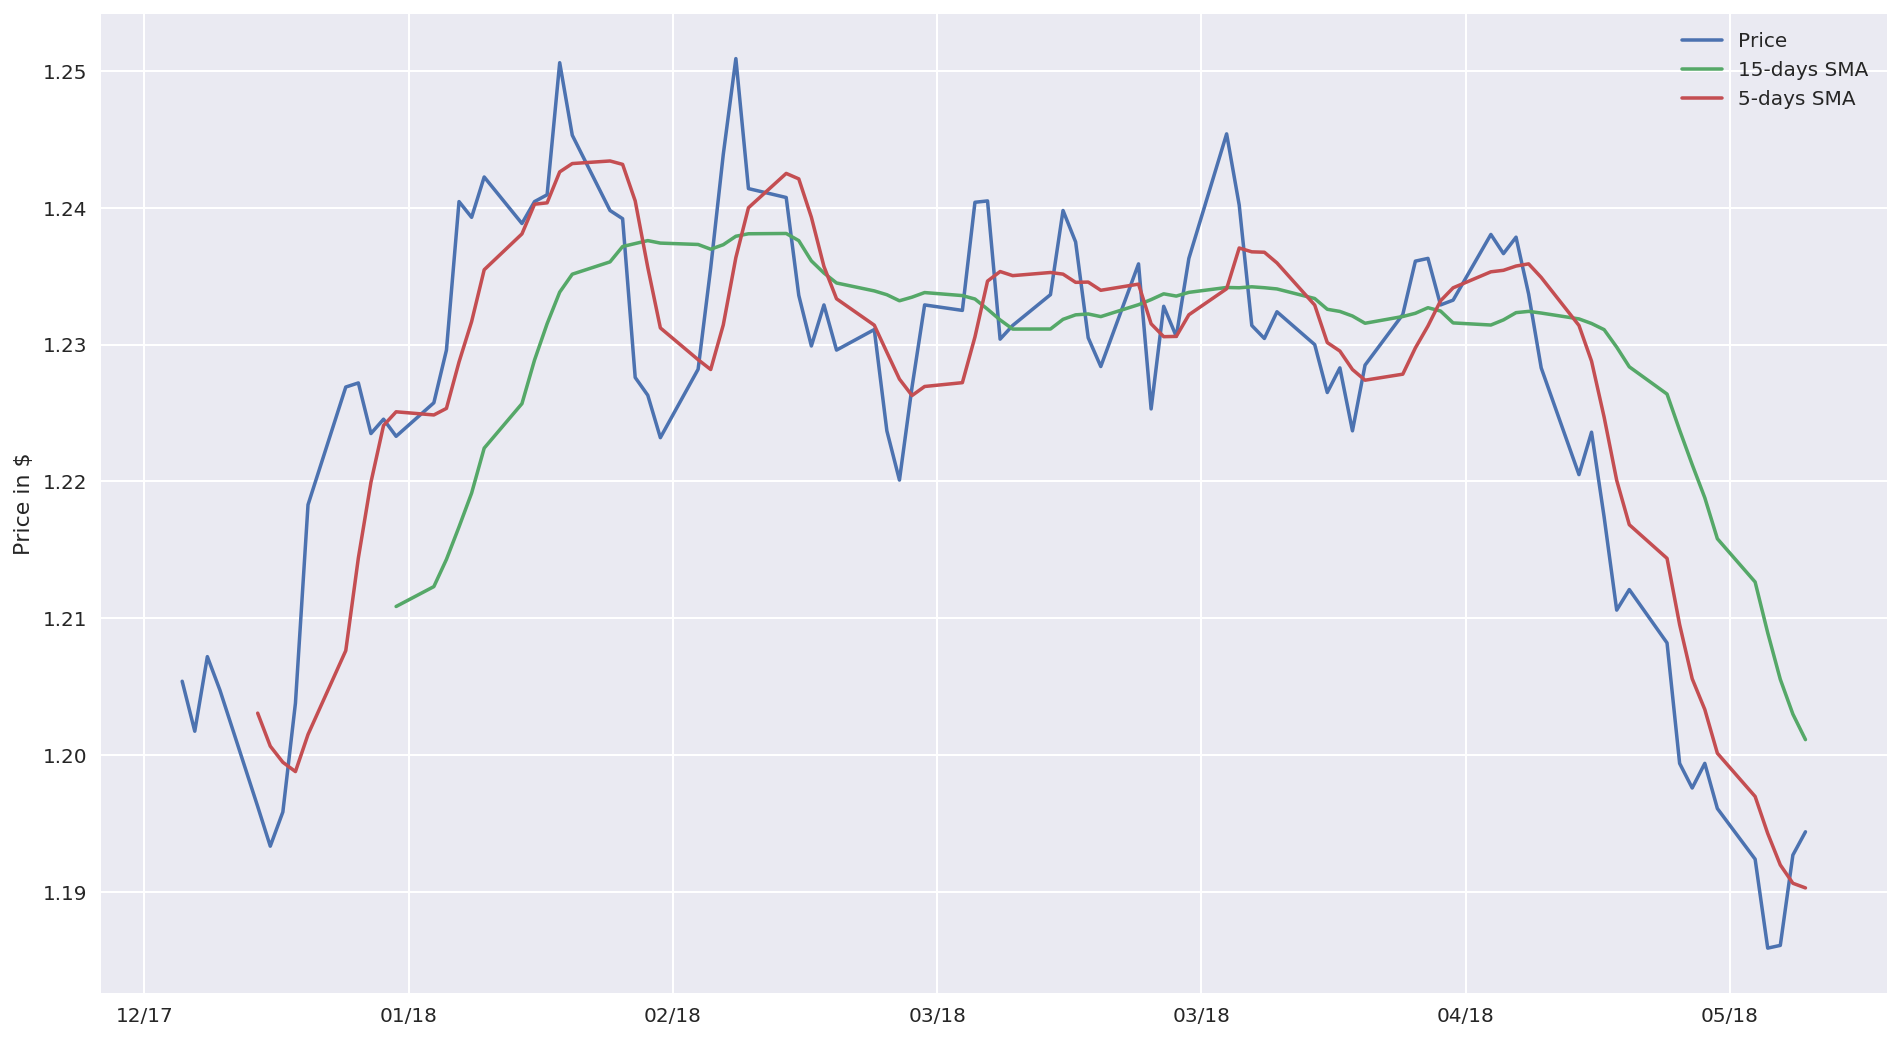

In [89]:
import matplotlib.dates as mdates
my_year_month_fmt = mdates.DateFormatter('%m/%y')

start_date = '2018-01-01'
end_date = '2018-05-11'

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(macro_filtered_dates.loc[start_date:end_date, :].index, macro_filtered_dates.loc[start_date:end_date, 'FX_USD.EUR'], label='Price')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'FX_USD.EUR'], label = '15-days SMA')
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'FX_USD.EUR'], label = '5-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.xaxis.set_major_formatter(my_year_month_fmt)
    

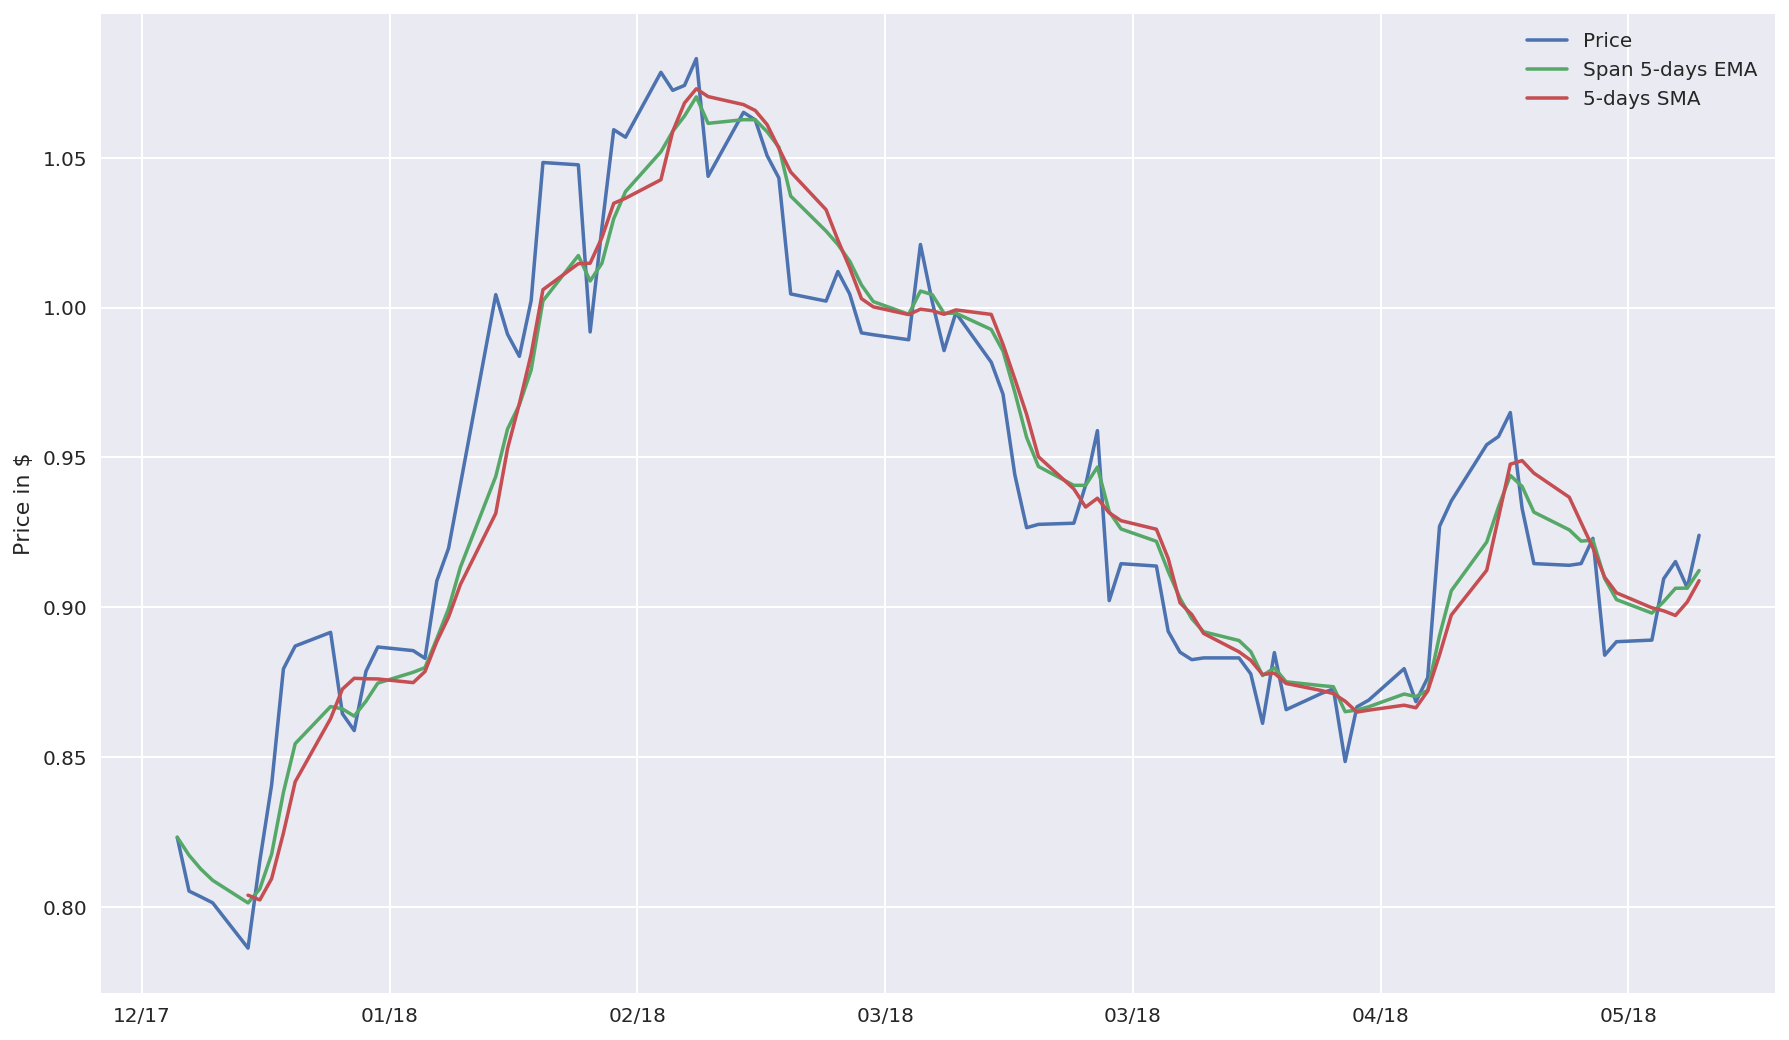

In [103]:
ema_short = macro_filtered_dates.ewm(span=5, adjust=False).mean()

fig, ax = plt.subplots(figsize=(15,9))

ax.plot(macro_filtered_dates.loc[start_date:end_date, :].index, macro_filtered_dates.loc[start_date:end_date, 'Swap_EUR10Y'], label='Price')
ax.plot(ema_short.loc[start_date:end_date, :].index, ema_short.loc[start_date:end_date, 'Swap_EUR10Y'], label = 'Span 5-days EMA')
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'Swap_EUR10Y'], label = '5-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.xaxis.set_major_formatter(my_year_month_fmt)
    

In [112]:
w.head()

,TradeDateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest,DaysSinceBuySell,DaysSinceTransaction,DaysSinceCustomerActivity,DaysSinceBondActivity,DaysCountBuySell,DaysCountTransaction,DaysCountCustomerActivity,DaysCountBondActivity
0,20180205,0,21856,Buy,0.0,219,219,4,6,0,0,5,4
1,20180205,0,21856,Sell,0.0,219,219,4,6,0,0,5,4
2,20180205,0,24944,Buy,0.0,219,219,4,21,0,0,5,3
3,20180205,0,24944,Sell,0.0,219,219,4,21,0,0,5,3
4,20180205,0,25992,Buy,0.0,219,219,4,3,0,0,5,15


In [122]:
ema_fx_usd = ema_short[['DateKey','FX_USD.EUR']].reset_index()
ema_fx_usd.head()

,Date,DateKey,FX_USD.EUR
0,2018-01-02,2.018010e+07,1.205400
1,2018-01-03,2.018010e+07,1.204183
2,2018-01-04,2.018010e+07,1.205189
3,2018-01-05,2.018010e+07,1.205043
4,2018-01-08,2.018011e+07,1.202112


In [131]:
ema_fx_usd['DateKey'] = ema_fx_usd['DateKey'].astype(int).apply(utils.date2num)

# Preprocessing

In [41]:
cat_cols = ['BuySell', 'Sector', 'Subsector', 'Region_x', 'Country', 
            'TickerIdx', 'Seniority', 'Currency', 'ActivityGroup', 
            'Region_y', 'Activity', 'RiskCaptain', 'Owner', 'CompositeRating', 
            'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType']

In [42]:
id_cols = ['TradeDateKey', 'CustomerIdx', 'IsinIdx']
target_col = 'CustomerInterest'
pred_col = 'PredictionIdx'

In [ ]:
from src.utils import apply_cats
for col in cat_cols:
    weeks[-1][col] = weeks[-1][col].astype('category').cat.as_ordered()

In [ ]:
for w in weeks[:-1]:
    apply_cats(w, weeks[-1])

In [ ]:
for w in weeks:
    for col in cat_cols:
        w[col] = w[col].cat.codes

# Train/Test/Val

In [ ]:
from src.utils import run_model
from lightgbm import LGBMClassifier
metric_names = ['auc']

In [ ]:
for i, w in enumerate(weeks[1:]):
    train, val, test = weeks[i], w, weeks[-1]
    print(train['TradeDateKey'].unique(), 
          val['TradeDateKey'].unique(), 
          test['TradeDateKey'].unique())

In [ ]:
%%time
results = None
output = []
for i, w in enumerate(weeks[1:]):
    train, val, test = weeks[i], w, weeks[-1]
    X_train, y_train = train.drop(id_cols + [target_col], axis=1), \
                       train[target_col]
    if pred_col in val.columns: # when test acts as validation
        X_val, y_val = None, None
    else:
        X_val, y_val = val.drop(id_cols + [target_col], axis=1), \
                       val[target_col]
    X_test = test.drop(id_cols + [target_col, pred_col], axis=1)
        
    y_test, _, results, model = run_model(
            LGBMClassifier(n_estimators=120),
            X_train, y_train, X_val, y_val, X_test,
            metric_names, results, 
            params_desc='n_estimators=120',
            dataset_desc=f'{week_labels[i]}_diffcounts', 
            early_stopping=True)
    output.append([y_test, model])

In [ ]:
results

In [56]:
results

,dataset,model,params,time,trn_auc_mean,val_auc_mean
0,20180226_diffcounts,LGBMClassifier,n_estimators=120,7.78,0.801433,0.656208
1,20180305_diffcounts,LGBMClassifier,n_estimators=120,5.52,0.763234,0.695151
2,20180312_diffcounts,LGBMClassifier,n_estimators=120,5.24,0.753722,0.727934
3,20180319_diffcounts,LGBMClassifier,n_estimators=120,8.19,0.814878,0.675515
4,20180326_diffcounts,LGBMClassifier,n_estimators=120,7.35,0.812643,0.706836
5,20180402_diffcounts,LGBMClassifier,n_estimators=120,5.81,0.799783,0.739328
6,20180409_diffcounts,LGBMClassifier,n_estimators=120,6.84,0.827979,0.771319
7,20180416_diffcounts,LGBMClassifier,n_estimators=120,3.60,0.844436,0.000000


In [40]:
results

,dataset,model,params,time,trn_auc_mean,val_auc_mean
0,20180226_diffcounts,LGBMClassifier,n_estimators=120,7.69,0.792226,0.655294
1,20180305_diffcounts,LGBMClassifier,n_estimators=120,5.12,0.749205,0.695170
2,20180312_diffcounts,LGBMClassifier,n_estimators=120,6.71,0.779543,0.728900
3,20180319_diffcounts,LGBMClassifier,n_estimators=120,8.20,0.809460,0.683462
4,20180326_diffcounts,LGBMClassifier,n_estimators=120,7.18,0.809129,0.705596
5,20180402_diffcounts,LGBMClassifier,n_estimators=120,5.23,0.787410,0.738378
6,20180409_diffcounts,LGBMClassifier,n_estimators=120,6.74,0.818286,0.772272
7,20180416_diffcounts,LGBMClassifier,n_estimators=120,3.52,0.841613,0.000000


In [148]:
results

,dataset,model,params,time,trn_auc_mean,val_auc_mean
0,20180226_diffcounts,LGBMClassifier,n_estimators=120,8.04,0.813655,0.655689
1,20180305_diffcounts,LGBMClassifier,n_estimators=120,5.16,0.757246,0.693547
2,20180312_diffcounts,LGBMClassifier,n_estimators=120,6.54,0.785328,0.729307
3,20180319_diffcounts,LGBMClassifier,n_estimators=120,6.18,0.775792,0.678395
4,20180326_diffcounts,LGBMClassifier,n_estimators=120,7.74,0.830289,0.705754
5,20180402_diffcounts,LGBMClassifier,n_estimators=120,4.97,0.783423,0.736578
6,20180409_diffcounts,LGBMClassifier,n_estimators=120,6.74,0.830874,0.772098
7,20180416_diffcounts,LGBMClassifier,n_estimators=120,3.49,0.841493,0.000000


In [139]:
results

,dataset,model,params,time,trn_auc_mean,val_auc_mean
0,20180226_diffcounts,LGBMClassifier,n_estimators=120,6.84,0.780921,0.656573
1,20180305_diffcounts,LGBMClassifier,n_estimators=120,4.51,0.735274,0.693338
2,20180312_diffcounts,LGBMClassifier,n_estimators=120,6.87,0.781854,0.728517
3,20180319_diffcounts,LGBMClassifier,n_estimators=120,8.31,0.812702,0.683438
4,20180326_diffcounts,LGBMClassifier,n_estimators=120,8.09,0.824718,0.704264
5,20180402_diffcounts,LGBMClassifier,n_estimators=120,5.60,0.790260,0.736316
6,20180409_diffcounts,LGBMClassifier,n_estimators=120,6.38,0.813713,0.771199
7,20180416_diffcounts,LGBMClassifier,n_estimators=120,3.27,0.843070,0.000000


In [105]:
results

,dataset,model,params,time,trn_auc_mean,val_auc_mean
0,20180226_diffcounts,LGBMClassifier,n_estimators=120,11.94,0.795231,0.654387
1,20180305_diffcounts,LGBMClassifier,n_estimators=120,7.43,0.749922,0.694827
2,20180312_diffcounts,LGBMClassifier,n_estimators=120,10.32,0.794540,0.729287
3,20180319_diffcounts,LGBMClassifier,n_estimators=120,11.64,0.789302,0.680462
4,20180326_diffcounts,LGBMClassifier,n_estimators=120,12.10,0.820079,0.706285
5,20180402_diffcounts,LGBMClassifier,n_estimators=120,4.33,0.735760,0.731898
6,20180409_diffcounts,LGBMClassifier,n_estimators=120,11.22,0.825966,0.770442
7,20180416_diffcounts,LGBMClassifier,n_estimators=120,6.62,0.841095,0.000000


In [29]:
results

,dataset,model,params,time,trn_auc_mean,val_auc_mean
0,20180226_diffcounts,LGBMClassifier,n_estimators=120,12.62,0.800578,0.654793
1,20180305_diffcounts,LGBMClassifier,n_estimators=120,9.34,0.764028,0.694719
2,20180312_diffcounts,LGBMClassifier,n_estimators=120,9.86,0.770449,0.728249
3,20180319_diffcounts,LGBMClassifier,n_estimators=120,12.95,0.804084,0.676341
4,20180326_diffcounts,LGBMClassifier,n_estimators=120,10.54,0.806556,0.705754
5,20180402_diffcounts,LGBMClassifier,n_estimators=120,8.53,0.781100,0.739115
6,20180409_diffcounts,LGBMClassifier,n_estimators=120,10.44,0.832328,0.771817
7,20180416_diffcounts,LGBMClassifier,n_estimators=120,5.76,0.843448,0.000000


In [42]:
test[target_col] = np.mean([x[0] for x in output], axis=0)

# Submission

In [43]:
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
submission = pd.merge(submission[['PredictionIdx']], test[['PredictionIdx', target_col]], 
                      how='left', on='PredictionIdx')

In [44]:
submission.to_csv(SUBMISSIONS/'06-lgbm_8weeks_diffscount_0212-0416.csv', index=False)